## Q1

Computer vision is a subfield of machine learning and AI that allows computers to analyze and respond to visual information such as images and videos. This technology has become the backbone of many industries, including manufacturing, consumer goods, agriculture, medicine, and so on. The global market for computer vision was expected to reach $48.6 billion by 2022.

## Q2

In [32]:
# Only run if need to unzip the file downloaded from Kaggle
# import zipfile
# import os

# def extract_zip_file(zip_file_path, dest_path):
#     # Ensure the destination path exists
#     if not os.path.exists(dest_path):
#         os.makedirs(dest_path)

#     with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#         zip_ref.extractall(dest_path)
        

# # Use the function
# zip_file_path = 'archive.zip'  # replace with your zip file path
# dest_path = os.getcwd()  # get current working directory
# extract_zip_file(zip_file_path, dest_path)

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the .txt file as a pandas DataFrame
def load_labels(file_path):
    df = pd.read_csv(file_path, sep=" ", header=None)
    df.columns = ["filename", "target"]
    df['filename'] = df.apply(lambda row: os.path.join(str(row['target']), row['filename']), axis=1)
    df["target"] = df["target"].astype(str)
    df['filename'] = df['filename'].astype(str)  # Convert class column to string type
    return df

train_df = load_labels("train.txt")
test_df = load_labels("test.txt")
val_df = load_labels("val.txt")

2023-05-19 21:18:44.517866: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-19 21:18:44.543773: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 21:18:44.933121: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
batch_size = 32
img_height = 64
img_width = 64

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(train_df, directory="classification/train", 
                                                    x_col="filename", y_col="target",
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batch_size, class_mode='categorical')

validation_generator = train_datagen.flow_from_dataframe(val_df, directory="classification/val", 
                                                         x_col="filename", y_col="target",
                                                         target_size=(img_height, img_width), 
                                                         batch_size=batch_size, class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(test_df, directory="classification/test", 
                                                  x_col="filename", y_col="target", 
                                                  target_size=(img_height, img_width), 
                                                  batch_size=batch_size, class_mode='categorical', shuffle=False)


Found 45095 validated image filenames belonging to 102 classes.
Found 7508 validated image filenames belonging to 102 classes.
Found 22619 validated image filenames belonging to 102 classes.


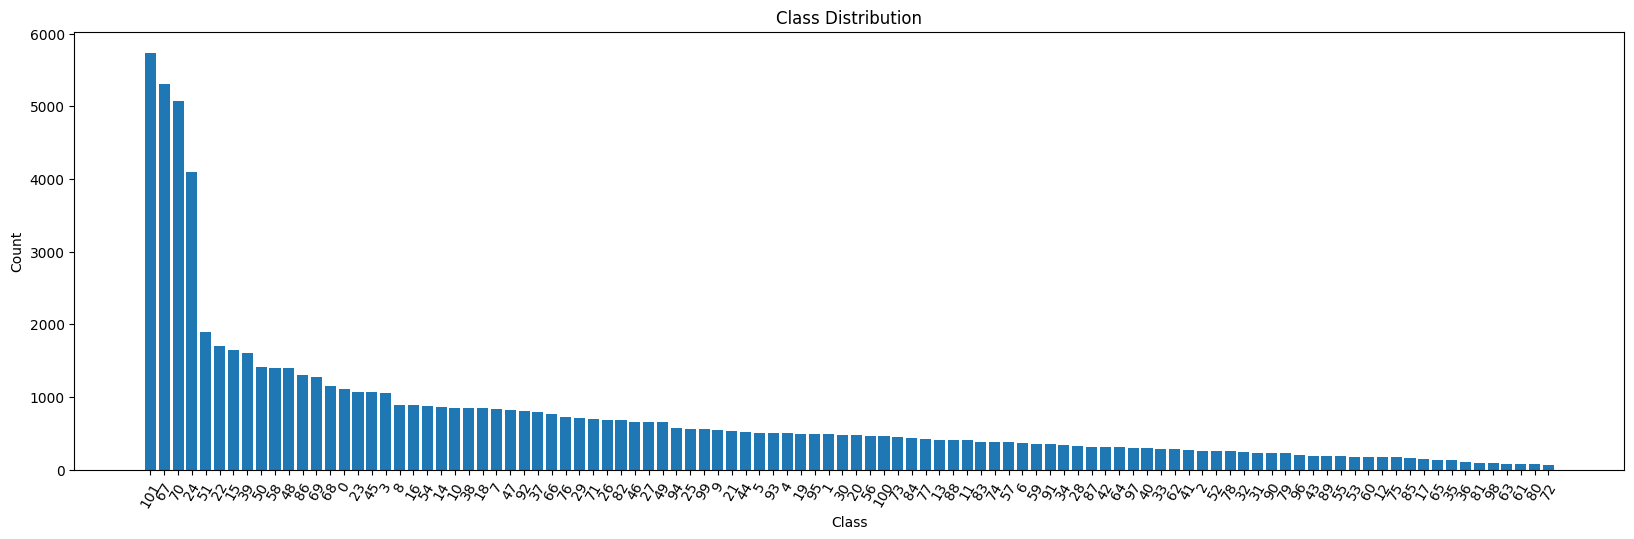

In [17]:
all_labels = pd.concat([train_df, test_df, val_df], axis = 0)
class_dist = all_labels.target.value_counts()
plt.figure(figsize=(20,6))
plt.bar(class_dist.index, class_dist.values)
plt.tick_params(axis='x', which='major', labelsize=10)  # Change label size to 10
plt.xticks(range(len(class_dist.index)), class_dist.index, rotation=60)
plt.subplots_adjust(bottom=0.15)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [24]:
# Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2

def create_model(input_shape, optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']):
    model = Sequential([
        Conv2D(32, (3,3), activation = 'relu', input_shape = (input_shape[0], input_shape[1], 3), kernel_regularizer = l1_l2(l1=1e-5, l2=1e-4)),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),

        Conv2D(64, (3,3), activation = 'relu', kernel_regularizer = l1_l2(l1=1e-5, l2=1e-4)),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),

        Flatten(),
        Dense(1024, activation = 'relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(102, activation='softmax') #102 classes

    ])

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [27]:
m1 = create_model((img_height, img_width))
history = m1.fit(train_generator, epochs = 100, validation_data = validation_generator)

Epoch 1/100


2023-05-19 23:00:15.076621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-19 23:00:15.491818: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1410/1410 [==============================] - ETA: 0s - loss: 4.1674 - accuracy: 0.1309

2023-05-19 23:01:12.330102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1410/1410 [==============================] - 67s 46ms/step - loss: 4.1674 - accuracy: 0.1309 - val_loss: 3.8106 - val_accuracy: 0.1585
Epoch 2/100
1410/1410 [==============================] - 64s 45ms/step - loss: 3.6115 - accuracy: 0.1907 - val_loss: 3.5023 - val_accuracy: 0.2032
Epoch 3/100
1410/1410 [==============================] - 65s 46ms/step - loss: 3.3621 - accuracy: 0.2241 - val_loss: 3.4240 - val_accuracy: 0.2326
Epoch 4/100
1410/1410 [==============================] - 65s 46ms/step - loss: 3.1284 - accuracy: 0.2654 - val_loss: 3.1939 - val_accuracy: 0.2730
Epoch 5/100
1410/1410 [==============================] - 65s 46ms/step - loss: 2.9545 - accuracy: 0.2938 - val_loss: 3.1155 - val_accuracy: 0.2752
Epoch 6/100
1410/1410 [==============================] - 65s 46ms/step - loss: 2.8348 - accuracy: 0.3180 - val_loss: 3.2014 - val_accuracy: 0.2599
Epoch 7/100
1410/1410 [==============================] - 65s 46ms/step - loss: 2.7029 - accuracy: 0.3439 - val_loss: 3.2415 - val_

In [28]:
# So i dont have to retrain model if i repoen this file.
m1.save("model_1.h5")

In [29]:
m1.save("model_1")

2023-05-20 00:52:01.358843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,31,31,32]
	 [[{{node inputs}}]]
2023-05-20 00:52:01.366704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,14,14,64]
	 [[{{node inputs}}]]
2023-05-20 00:52:01.374765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-

INFO:tensorflow:Assets written to: model_1/assets


INFO:tensorflow:Assets written to: model_1/assets
